In [22]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import os
import sys
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import glob


def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)

In [3]:
#Root directory and the bedfiles for the non-reference and reference insertions
ervDir = '/home/ampend/links/kidd-lab/ampend-projects/cfERVs/'
permutationDir = ervDir + 'GenePermutations/' 
ervFile = permutationDir + 'input/' + 'Total_cfERVInsertionSites_2017-06-29.bed'

In [4]:
gapBedFile = permutationDir + 'input/' + 'CF3_gaps.bed'
genomeFile = permutationDir + 'input/' + 'Cf3_allchrom_withUn.genome'

#Intersect new bedfile with genes with 0 and 50kb window sizes
windowSizes = ['0','10000','50000']


In [5]:
########################################################################################
def do_window_intersects(a,b,windowSize,outfile):
    cmd = 'bedtools window -w %i -a %s -b %s > %s' % (windowSize, a, b, outfile)
    #print(cmd)
    runCMD(cmd)
##############################################################################################################
def make_ensG_dict(ervfile):
    ensGDict = {}
    for line in open(ervfile,'r'):
        line = line.rstrip().split()
        winID = line[3]
        ensGDict[winID] = [[],[]] #0kb, 50kb  
    return ensGDict
#################################################################################################################################
def parse_gene_intersect_file(windowLength,intfile):
    #intfile = permutationDir + 'results/' + windowLength + 'bpWindowIntersect_%sERVs_with_EnsemblGenes.txt' % Type
    intersectFile = open(intfile,'r') #outfile from the intersect step with ensembl 81 genes

    ensID = ''
    sigGenes = [] #To keep track of all gene IDs (ENSCAFG) that are in sig windows

    #Reading the intersect file results
    for line in intersectFile:
        line = line.rstrip() #removing extraneous whitespace characters
        line = line.split() #delimiting "columns" in the file based on tabs		
        winID = line[3]
        hit = line[7].split('_')
        Protein = hit[0]
        Gene = hit[1]
        b2goID = Gene + '|' + Protein
        ensGID = hit[2]
        if winID not in ensGDict.keys():
            ensGDict[winID] = []
        ensGDict[winID].append(ensGID)
    intersectFile.close()
   
    return ensGDict

In [6]:
#INTERSECTING REAL CFERVS
ervfile = ervFile #ervfile is same as above output file
totalERVCount = count_lines(ervfile)
genebedfile = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/results/BLAST2GO_Ensembl81_GeneTables_WithEnscafIDsAndChrom.bed'
real_genicCount,real_near10kbCount, real_near50kbCount = 0, 0, 0
for windowSize in windowSizes:
    ensGDict = {}
    outfile = permutationDir + 'REALERVS' + str(windowSize) + 'bpWindowIntersect_cfERVs_with_EnsemblGenes.txt'
    do_window_intersects(ervfile,genebedfile,int(windowSize),outfile)
    ensGDict = parse_gene_intersect_file(windowSize,outfile)
    if '0' == windowSize:
        real_genicCount = len(ensGDict.keys())
    if '10000' in windowSize:
        real_near10kbCount = len(ensGDict.keys())
    if '50000' in windowSize:
        real_near50kbCount = len(ensGDict.keys())

print('Real number of within gene insertions = ',real_genicCount)
print('Real number of insertions with 10kb of at least one gene = ',real_near10kbCount)
print('Real number of insertions with 50kb of at least one gene = ',real_near50kbCount)

Real number of within gene insertions =  30
Real number of insertions with 10kb of at least one gene =  51
Real number of insertions with 50kb of at least one gene =  96


In [ ]:
"""#PERMUTATIONS FROM SHUFFLING THE REAL CFERV POSITIONS AROUND

genicInsertCountList, near10kbGeneInsertCountList, near50kbGeneInsertCountList = [], [], [] #0kb, 10kb, 50kb (respectively)
permList = [] #keeping track of permutations
for i in range(0,1000):
    #1. Generate new bedfile for cfERV insertions
    outfile = permutationDir + 'results/' + 'cfERV_GenePermutation_%i.bed' % i
    cmd = 'bedtools shuffle -i %s -excl %s -g %s > %s' % (ervFile, gapBedFile,genomeFile,outfile)
    #print(cmd)
    runCMD(cmd)
    
    #files for intersect
    ervfile = outfile #ervfile is same as above output file
    genebedfile = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/results/BLAST2GO_Ensembl81_GeneTables_WithEnscafIDsAndChrom.bed'
    for windowSize in windowSizes:
        ensGDict = {}
        outfile = permutationDir + 'results/' + str(windowSize) + 'bpWindowIntersect_cfERVs_with_EnsemblGenes_%i.txt'% (i)
        do_window_intersects(ervfile,genebedfile,int(windowSize),outfile)
        ensGDict = parse_gene_intersect_file(windowSize,outfile)
        if '0' == windowSize:
            genicCount = len(ensGDict.keys())
        if '10000' in windowSize:
            near10kbCount = len(ensGDict.keys())
        if '50000' in windowSize:
            near50kbCount = len(ensGDict.keys())

    genicInsertCountList.append(genicCount)
    near10kbGeneInsertCountList.append(near10kbCount)
    near50kbGeneInsertCountList.append(near50kbCount)
    if i % 25 == 0:
        print(i)
print('DONE!!!')
print('Average number of within gene insertions = ',np.mean(genicInsertCountList))
print('Average number of insertions with 10kb of at least one gene = ',np.mean(near10kbGeneInsertCountList))
print('Average number of insertions with 50kb of at least one gene = ',np.mean(near50kbGeneInsertCountList))"""

# Within gene insertion statistics

In [ ]:
#IN GENE INSERTION (0KB)
print('Number of ERV insertions within a gene from REAL data = ', real_genicCount)
#Test of normalcy for the genic insertion frequency distribution
W, p = stats.shapiro(genicInsertCountList) # = W (test statistic), p-value
print('\np-value for Ho of normal dist = ', p)
#significance of the genic insertion frequencies
genicMean = np.mean(genicInsertCountList)
print('\nAverage number of genic insertions from 1000 permutations = ', genicMean)
oddsratio, pvalue = stats.fisher_exact([[real_genicCount,totalERVCount-real_genicCount], [genicMean, totalERVCount-genicMean]])
print('\nFisher exact test (2x2 contingency) p-value = ', pvalue)

obs = np.array([[real_genicCount,totalERVCount-real_genicCount], [genicMean, totalERVCount-genicMean]])
chi2, p, ddof, expected = stats.chi2_contingency(obs)
msg = "\n\nChi Square Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )

# Within 10kb insertion statistics

In [ ]:
#50KB FROM GENE INSERTIONS
print('Number of ERV insertions within 10kb of gene from REAL data = ', real_near10kbCount)
#Test of normalcy for the near gene insertion frequency distribution
W, p = stats.shapiro(near10kbGeneInsertCountList) # = W (test statistic), p-value
print('\np-value for Ho of non-normal data = ', p)
#significance of the near gene insertion frequencies
near10kbGenicMean = np.mean(near10kbGeneInsertCountList)
print('\nAverage number of insertions within 10kb of a gene from 1000 permutations = ', near10kbGenicMean)
oddsratio, pvalue = stats.fisher_exact([[real_near10kbCount,totalERVCount-real_near10kbCount], [near10kbGenicMean, totalERVCount-near10kbGenicMean]])
print('\nFisher exact test (2x2 contingency) p-value = ', pvalue)

obs = np.array([[real_nearCount,totalERVCount-real_nearCount], [near10kbGenicMean, totalERVCount-nearGenicMean]])
chi2, p, ddof, expected = stats.chi2_contingency(obs)
msg = "\n\nChi Square Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )


# Within 50kb insertion statistics

In [ ]:
#50KB FROM GENE INSERTIONS
print('Number of ERV insertions within 50kb of gene from REAL data = ', real_near50kbCount)
#Test of normalcy for the near gene insertion frequency distribution
W, p = stats.shapiro(near50kbGeneInsertCountList) # = W (test statistic), p-value
print('\np-value for Ho of non-normal data = ', p)
#significance of the near gene insertion frequencies
near50kbGenicMean = np.mean(near50kbGeneInsertCountList)
print('\nAverage number of insertions within 50kb of a gene from 1000 permutations = ', near50kbGenicMean)
oddsratio, pvalue = stats.fisher_exact([[real_near50kbCount,totalERVCount-real_near50kbCount], [near50kbGenicMean, totalERVCount-near50kbGenicMean]])
print('\nFisher exact test (2x2 contingency) p-value = ', pvalue)

obs = np.array([[real_near50kbCount,totalERVCount-real_near50kbCount], [near50kbGenicMean, totalERVCount-near50kbGenicMean]])
chi2, p, ddof, expected = stats.chi2_contingency(obs)
msg = "\n\nChi Square Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )


# Saving the original permutation data so you dont have to run it again

In [ ]:
"""outFile = open(permutationDir + 'genic_insertions_1000permutations.txt','w') 
#Saving the permutations to an output file
for i in genicInsertCountList:
    outFile.write(str(i) + '\n')
outFile.close()

outFile = open(permutationDir + 'near10kbgenic_insertions_1000permutations.txt','w') 
#Saving the permutations to an output file
for i in near10kbGeneInsertCountList:
    outFile.write(str(i) + '\n')
outFile.close()

outFile = open(permutationDir + 'near50kbgenic_insertions_1000permutations.txt','w') 
#Saving the permutations to an output file
for i in near50kbGeneInsertCountList:
    outFile.write(str(i) + '\n')
outFile.close()"""

In [8]:
genicInsertCountList,near10kbGeneInsertCountList,near50kbGeneInsertCountList = [], [], []
inFile = open(permutationDir + 'genic_insertions_1000permutations.txt','r') 
#Saving the permutations to an output file
for line in inFile:
    line=line.rstrip()
    genicInsertCountList.append(int(line))
inFile.close()

inFile = open(permutationDir + 'near10kbgenic_insertions_1000permutations.txt','r') 
#Saving the permutations to an output file
for line in inFile:
    line=line.rstrip()
    near10kbGeneInsertCountList.append(int(line))
inFile.close()

inFile = open(permutationDir + 'near50kbgenic_insertions_1000permutations.txt','r') 
#Saving the permutations to an output file
for line in inFile:
    line=line.rstrip()
    near50kbGeneInsertCountList.append(int(line))
inFile.close()


# Plotting the permutation distributions

In [12]:
###################################################################
def simpleaxis(ax): #takes away the right and top borders/axes of a plot or subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

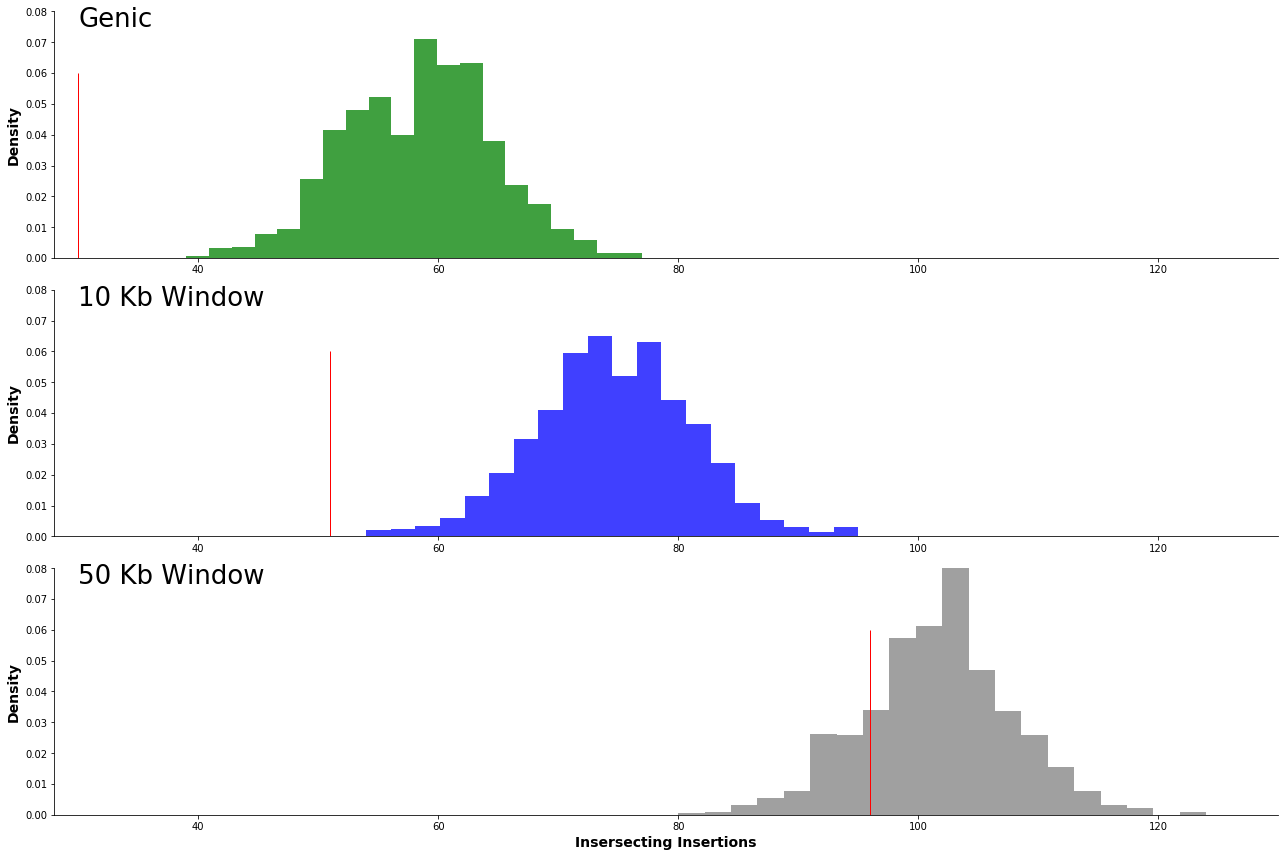

In [47]:
f, axarr = plt.subplots(3, sharex=True, figsize=(18,12))
#PLOT ONE = GENIC
axarr[0].hist(genicInsertCountList, 20, normed=1, facecolor='green', alpha=0.75,histtype="stepfilled")
axarr[0].vlines(x=real_genicCount,ymin=0,ymax=0.06, lw=1,color="red")
axarr[0].set_xlim(28,130)
axarr[0].set_ylim(0,0.08)
simpleaxis(axarr[0])
axarr[0].text(30,0.075,'Genic',fontsize=26)
axarr[0].set_ylabel('Density', fontsize=14,fontweight='bold')
#PLOT TWO = 10kb
axarr[1].hist(near10kbGeneInsertCountList, 20, normed=1, facecolor='blue', alpha=0.75,histtype="stepfilled")
axarr[1].vlines(x=real_near10kbCount,ymin=0,ymax=0.06, lw=1,color="red")
axarr[1].set_xlim(28,130)
axarr[1].set_ylim(0,0.08)
simpleaxis(axarr[1])
axarr[1].text(30,0.075,'10 Kb Window',fontsize=26)
axarr[1].set_ylabel('Density', fontsize=14,fontweight='bold')
#PLOT THREE = 50kb
axarr[2].hist(near50kbGeneInsertCountList, 20, normed=1, facecolor='gray', alpha=0.75,histtype="stepfilled")
axarr[2].vlines(x=real_near50kbCount,ymin=0,ymax=0.06, lw=1,color="red")
axarr[2].set_xlim(28,130)
axarr[2].set_ylim(0,0.08)
axarr[2].set_xlabel('Insersecting Insertions', fontsize=14,fontweight='bold')
axarr[2].set_ylabel('Density', fontsize=14,fontweight='bold')
axarr[2].text(30,0.075,'50 Kb Window',fontsize=26)
simpleaxis(axarr[2])
#Draw plot
f.tight_layout()
f.savefig(permutationDir + 'FinalPlot_0kb_10kb_50kb_1000PermutationHistogram.png')